# Prophet algorithm for time-series forecasting

In [1]:
#install prophet if not done already
#!pip install prophet

In [2]:
import pandas as pd
import numpy as np

In [3]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv')

df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df['ds']=df['Month']
df['y'] = df['#Passengers']

In [5]:
print('size of dataset:', len(df))

size of dataset: 144


# Size of test dataset

In [6]:
Test_size = int(40) #last 40 values

In [7]:
train_df = df.head(len(df)-Test_size)
test_df = df.tail(Test_size) 

# Plot the series to see the dataset

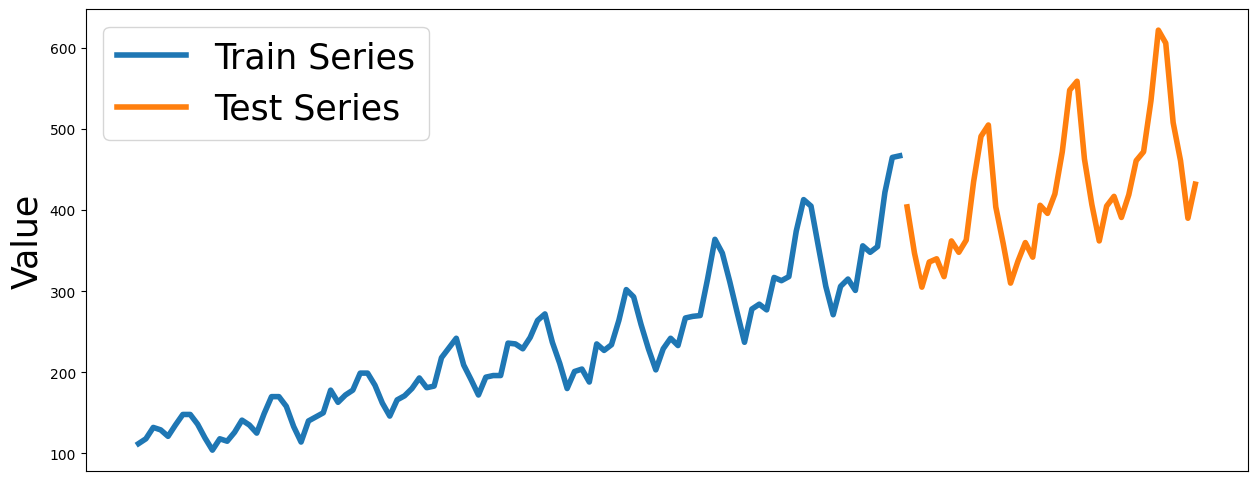

In [25]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(train_df['ds'], train_df['y'], linewidth = 4, label = "Train Series")
plt.plot(test_df['ds'], test_df['y'], linewidth = 4, label = "Test Series")


plt.legend(fontsize=25)
plt.ylabel('Value', fontsize = 25)
plt.xticks([])
plt.show()

# A simple fitting of Prophet Model: Without hyperparameter Tuning

In [9]:
# Disable the prophet logging 
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [10]:
#define loss function 

import numpy as np

def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


In [11]:
from prophet import Prophet
model = Prophet()
model.fit(train_df)
future = model.make_future_dataframe(periods=Test_size, freq='M')
forecast = model.predict(future)
predictions = forecast.tail(Test_size)

Importing plotly failed. Interactive plots will not work.


In [12]:
#predictions

## Get default predictions error

In [13]:
error = mape(test_df['y'], predictions['yhat'])   
print('error is:', error)

error is: 11.74


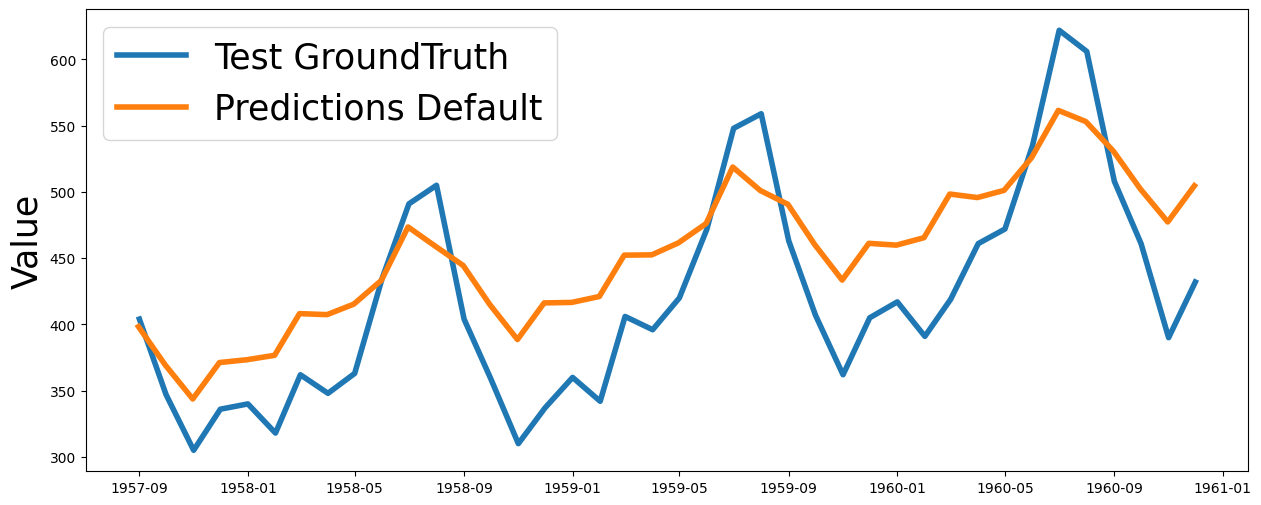

In [14]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(pd.to_datetime(test_df['ds']), test_df['y'], linewidth = 4, label = "Test GroundTruth")
plt.plot(pd.to_datetime(predictions['ds']), predictions['yhat'], linewidth = 4, label = "Predictions Default")

plt.legend(fontsize=25)
plt.ylabel('Value', fontsize = 25)
#plt.xticks([])
plt.show()

# Tune the hyperparameters

In [15]:
from prophet import Prophet
from mango import scheduler, Tuner


def objective_function(args_list):
    global train_df, test_df
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(train_df)
            future = model.make_future_dataframe(periods=Test_size, freq='M')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(Test_size)
            error = mape(test_df['y'], predictions_tuned['yhat'])   
            
            params_evaluated.append(params)
            results.append(error)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(25.0)# Giving high loss for exceptions regions of spaces
        
        #print(params_evaluated, mse)
    return params_evaluated, results

In [16]:
from scipy.stats import uniform


param_space = dict(growth = ['linear', 'logistic', 'flat'],
                   n_changepoints  = range(0, 55, 5),
                   changepoint_range  = uniform(0.5, 0.5),
                   yearly_seasonality = [True, False],
                   weekly_seasonality = [True, False],
                   daily_seasonality = [True, False],
                   seasonality_mode = ['additive', 'multiplicative'],
                   seasonality_prior_scale=uniform(5.0, 15.0),
                   changepoint_prior_scale=uniform(0.0, 0.1),
                   interval_width = uniform(0.2, 0.8),
                   uncertainty_samples = [500, 1000, 1500, 2000]
                   )

In [17]:
## see all hyperparameters allowed by prophet
#help(Prophet)

In [18]:
conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration'] = 50

In [19]:
tuner = Tuner(param_space, objective_function, conf_Dict)

In [20]:
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/50 [00:00<?, ?it/s]

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


best parameters: {'changepoint_prior_scale': 0.03645018575124749, 'changepoint_range': 0.5473968905424325, 'daily_seasonality': True, 'growth': 'linear', 'interval_width': 0.9544262800336518, 'n_changepoints': 45, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 16.83218918593137, 'uncertainty_samples': 1500, 'weekly_seasonality': True, 'yearly_seasonality': True}
best loss: 3.95


In [21]:
# ## See the variation of internal Mango's objective function

# from matplotlib import pyplot as plt
# fig = plt.figure(figsize=(30,5))
# plt.title('Variation of Objective',fontsize=20)
# plt.plot(results['objective_values'],lw=4,label='Mango objective')
# plt.xlabel('Iterations', fontsize=25)
# plt.ylabel('objective_values',fontsize=25)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.legend(fontsize = 20)
# plt.show()

# Train the best model and plot predictions

In [22]:
model = Prophet(**results['best_params'])
model.fit(train_df)
future = model.make_future_dataframe(periods=Test_size, freq='M')
forecast = model.predict(future)
predictions_tuned = forecast.tail(Test_size)

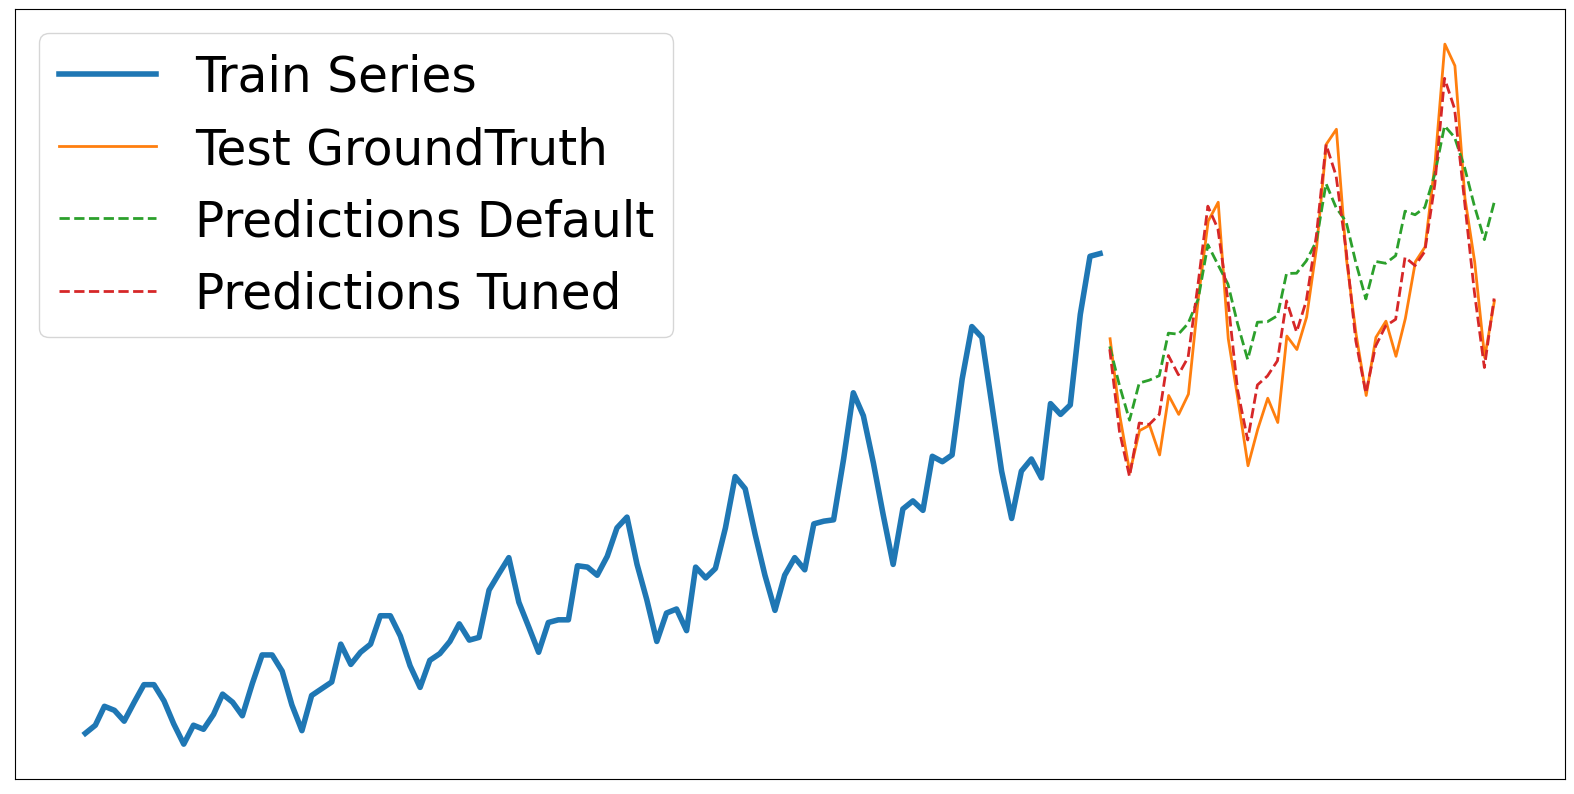

In [34]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(pd.to_datetime(train_df['ds']), train_df['y'], linewidth = 4, label = "Train Series")
plt.plot(pd.to_datetime(test_df['ds']), test_df['y'], linewidth = 2, label = "Test GroundTruth")
plt.plot(predictions['ds'], predictions['yhat'], linewidth = 2, label = "Predictions Default", linestyle='dashed')
plt.plot(predictions_tuned['ds'], predictions_tuned['yhat'], linewidth = 2, label = "Predictions Tuned", linestyle='dashed')

plt.legend(fontsize=35)
#plt.ylabel('Value', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()